In [1]:
import numpy as np
import cv2
import pandas as pd
import glob
from sklearn import svm
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from skimage.feature import hog
from sklearn.metrics import classification_report

## Functions
I prefer to have the functions all at the top of my notebook

In [2]:
def boundingBoxFromXML(path):
    '''takes and XML file path, returns the four corners of a bounding box
        depends on python xml 
        import xml.etree.ElementTree as ET
    '''
    
    #import the xml file and set a root
    tree = ET.parse(path)
    root = tree.getroot()
    
    #navigate to the bounding box
    root = root.find('object')    
    root = root.find('bndbox')
    
    #get the corners, order is xmin, ymin, xmax, ymax
    output = []
    for child in root:
        output.append( int(child.text) )
        
    return output

def getColorHistogram_X(image, channel):
    '''Takes and image and a target channel
        returns a color histrogam along the width of the image
    '''
    
    #container for results
    hist = []

    #loop over all the cols
    for i in range(image.shape[1]):

        #get the ith column
        col = image[:,i]

        #use numpy to get the sum of each channel for this col
        counts = np.sum(col, axis = 0)

        #return only the channel requested
        hist.append(counts[channel])

    return hist

def getColorHistogram_Y(image, channel):
    '''Takes and image and a target channel
        returns a color histrogam along the height of the image
    '''
    
    #container for results
    hist = []

    #loop over all the cols
    for i in range(image.shape[0]):

        #get the ith column
        col = image[i,:]

        #use numpy to get the sum of each channel for this col
        counts = np.sum(col, axis = 0)

        #return only the channel requested
        hist.append(counts[channel])

    return hist

## Read in ship images
Note here the image is a larger image with a single ship in it. I use the associated xml file to get the bounding box and then crop out a smaller image with a ship in it. 

In [3]:
#first read the image file paths
shipImagePaths = glob.glob("MASATI-v2/ship/*.png")

#next read the xml label file paths
shipLabelPaths = glob.glob("MASATI-v2/ship_labels/*.xml")

#container for ship images
imagesOfShips = []

#next loop over all the images and parse the XML file along the way
for i in range(1000):  #for now just 100 images
    
    #read the image with opencv
    image = cv2.imread(shipImagePaths[i])
    
    #parse the XML file to get the bounding box
    box = boundingBoxFromXML(shipLabelPaths[i])
    
    #crop out the ship using numpy
    imageCropped = image[box[1]:box[3], box[0]:box[2]] #[y:y+h, x:x+w] 
    
    #record the image
    imagesOfShips.append(imageCropped)

## Read in the images of ocean
Here I'll just read in the images and we can resize them later

In [4]:
#read the ocean image paths
oceanImagePaths = glob.glob("MASATI-v2/water/*.png")

#container for ocean images
imagesOfOcean = []

#loop 
for i in range(1000):
    
    #read in the image with opencv
    imagesOfOcean.append(cv2.imread(oceanImagePaths[i]))

## Some vis
Here I plot 36 random ships to get an idea what they look like in these image thumbnails

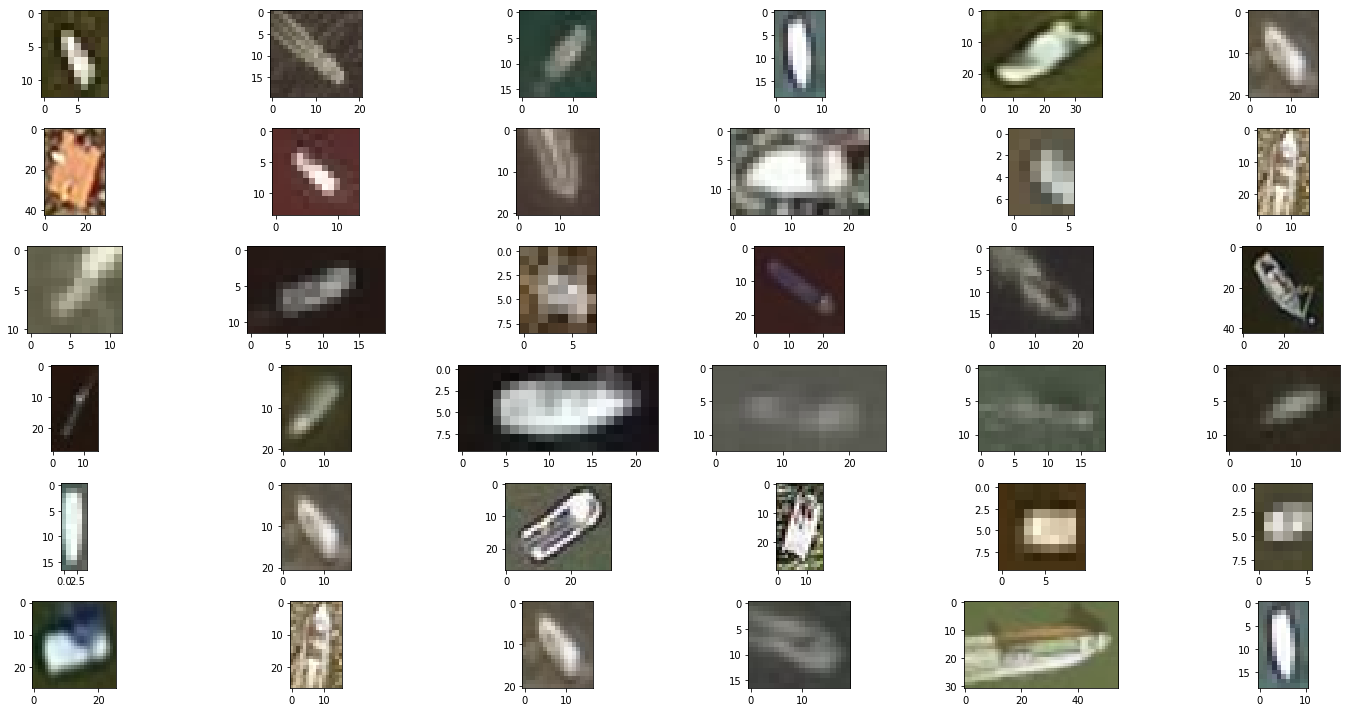

In [5]:
#plt subplot setup
fig, axs = plt.subplots(6, 6, figsize=(20, 10)) 

#loop to plot some random images for visulaztion purposes
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(imagesOfShips[np.random.randint(len(imagesOfShips))])
    
plt.tight_layout()
plt.show()

## Get some color histograms

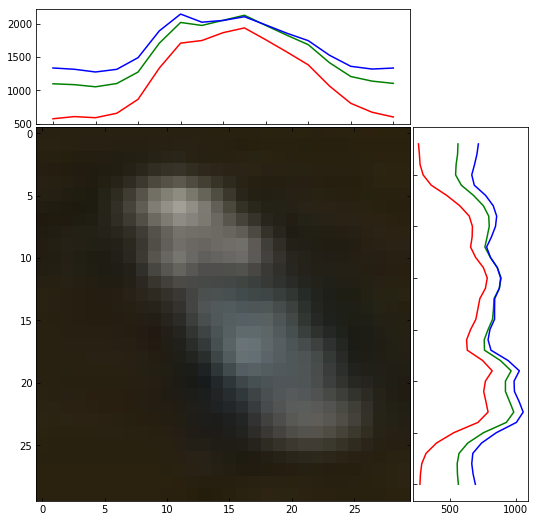

In [6]:
#histogram of a ship

#grab a random image
imageRandom = imagesOfShips[np.random.randint(len(imagesOfShips))]

#get the x-axis histograms
redX = getColorHistogram_X(imageRandom, 2)
greenX = getColorHistogram_X(imageRandom, 1)
blueX = getColorHistogram_X(imageRandom, 0)

#get the indexes of the x-axis
pltX = np.linspace(0, len(redX) - 1, len(redX))

#get the y-axis histograms
redY = getColorHistogram_Y(imageRandom, 2)
greenY = getColorHistogram_Y(imageRandom, 1)
blueY = getColorHistogram_Y(imageRandom, 0)

#get the indexes of the y-axis
pltY = np.linspace(0, len(redY) - 1, len(redY))

##################
##plot break
##################

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

#plot the image
ax_scatter.imshow(cv2.resize(imageRandom, (30,30)))

#plot the histograms on the x-axis
ax_histx.plot(pltX, redX, 'r')
ax_histx.plot(pltX, greenX, 'g')
ax_histx.plot(pltX, blueX, 'b')

#plot the histrograms on the y-axis
ax_histy.plot(redY, pltY, 'r')
ax_histy.plot(greenY, pltY, 'g')
ax_histy.plot(blueY, pltY, 'b')

plt.show()

## Histogram of ocean

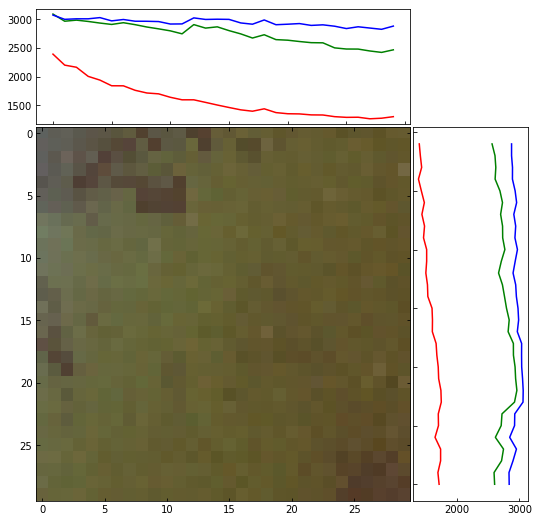

In [7]:
#histrogram of a water

#grab a random image
imageRandom = imagesOfOcean[np.random.randint(len(imagesOfOcean))]
imageRandom = cv2.resize(imageRandom, (30,30))

#get the x-axis histograms
redX = getColorHistogram_X(imageRandom, 2)
greenX = getColorHistogram_X(imageRandom, 1)
blueX = getColorHistogram_X(imageRandom, 0)

#get the indexes of the x-axis
pltX = np.linspace(0, len(redX) - 1, len(redX))

#get the y-axis histograms
redY = getColorHistogram_Y(imageRandom, 2)
greenY = getColorHistogram_Y(imageRandom, 1)
blueY = getColorHistogram_Y(imageRandom, 0)

#get the indexes of the y-axis
pltY = np.linspace(0, len(redY) - 1, len(redY))

##################
##plot break
##################

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

#plot the image
ax_scatter.imshow(imageRandom)

#plot the histograms on the x-axis
ax_histx.plot(pltX, redX, 'r')
ax_histx.plot(pltX, greenX, 'g')
ax_histx.plot(pltX, blueX, 'b')

#plot the histrograms on the y-axis
ax_histy.plot(redY, pltY, 'r')
ax_histy.plot(greenY, pltY, 'g')
ax_histy.plot(blueY, pltY, 'b')

plt.show()

## Train an SVM to classify images
Here I'll train an SVM for classification. The feature vector will consist of 6 vertically stacked histograms for each image. In order to make sure this vector is a constant size first I will resize all images to 30x30, then I extract histrograms.

In [8]:
#containers for data
features = []
labels = []

#loop over the ships to make feature vectors
for i in range(len(imagesOfShips)):
    
    #resize the image to 30x30
    image = cv2.resize(imagesOfShips[i], (30,30))
    
    #get the x-axis histograms
    redX = getColorHistogram_X(image, 2)
    greenX = getColorHistogram_X(image, 1)
    blueX = getColorHistogram_X(image, 0)
    
    #get the y-axis histograms
    redY = getColorHistogram_Y(image, 2)
    greenY = getColorHistogram_Y(image, 1)
    blueY = getColorHistogram_Y(image, 0)
    
    #compile a feature vector
    featureVector = np.array(redX + greenX + blueX + redY + greenY + blueY)
    
    #add to the dataset
    features.append(featureVector)
    labels.append(1)
    
#loop over the ocean to make feature vectors
for i in range(len(imagesOfOcean)):
    
    #resize the image to 30x30
    image = cv2.resize(imagesOfOcean[i], (30,30))
    
    #get the x-axis histograms
    redX = getColorHistogram_X(image, 2)
    greenX = getColorHistogram_X(image, 1)
    blueX = getColorHistogram_X(image, 0)
    
    #get the y-axis histograms
    redY = getColorHistogram_Y(image, 2)
    greenY = getColorHistogram_Y(image, 1)
    blueY = getColorHistogram_Y(image, 0)
    
    #compile a feature vector
    featureVector = np.array(redX + greenX + blueX + redY + greenY + blueY)
    
    #add to the dataset
    features.append(featureVector)
    labels.append(0)
    
#normalize the dataset
maxSet = np.max(features)
minSet = np.min(features)
for i in range(len(features)):
    
    #use min subtraction and max division norm
    features[i] = (features[i] - minSet) / (maxSet - minSet)
    
#shuffle the data
features, labels = shuffle(features, labels)

#split into training and validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

0.975


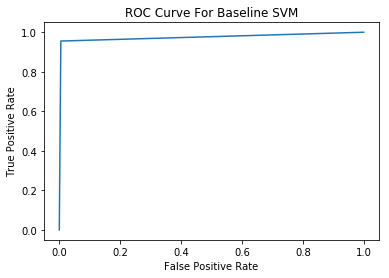

In [9]:
#train the SVM
clf_baseline = svm.SVC()
clf_baseline.fit(X_train, y_train)

#predict on the test dataset
predictions_baseline = clf_baseline.predict(X_test)

#get the accuracy
print (accuracy_score(y_test, predictions_baseline))

#generate the ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_baseline)

#plot the curve
plt.plot(fpr, tpr)
plt.title("ROC Curve For Baseline SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Now that we have something working, lets see which of the SVM kernels works the best
Below you will see that the rbf kernel returns the highest performance, I'll move forward with that

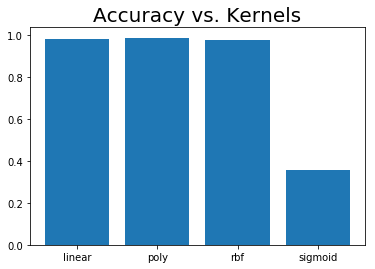

0.975


In [10]:
#check some kernel options
kernel_options = ["linear", "poly", "rbf", "sigmoid"]
performance = []

for ker in kernel_options:
    
    #train a model
    clf = svm.SVC(kernel=ker)
    clf.fit(X_train, y_train)
    
    #predict on the test dataset
    predictions = clf.predict(X_test)

    #get the accuracy
    performance.append(accuracy_score(y_test, predictions))

#plot
plt.title("Accuracy vs. Kernels", fontsize = 20)
plt.bar([0,1,2,3], performance)
plt.xticks([0,1,2,3],kernel_options)
plt.show()

#train the model with the best kernel
clf_best_kernel = svm.SVC()
clf_best_kernel.fit(X_train, y_train)

#predict on the test dataset
predictions_best_kernel = clf_best_kernel.predict(X_test)

#get the accuracy
print (accuracy_score(y_test, predictions_best_kernel))

## Now that RBF has been tested as the best kernel, tune the remaining parameters

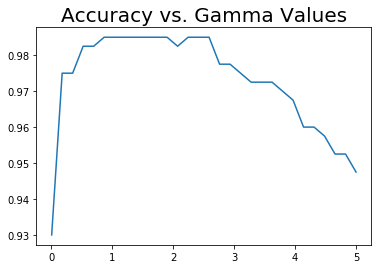

0.985
5
0.870344827586


In [11]:
#lets tune gamma
gamma_list = np.linspace(.01,5,30)
performance = []

for gam in gamma_list:
    
    #train a model
    clf = svm.SVC(gamma=gam)
    clf.fit(X_train, y_train)
    
    #predict on the test dataset
    predictions = clf.predict(X_test)

    #get the accuracy
    performance.append(accuracy_score(y_test, predictions))
    
#plot
plt.title("Accuracy vs. Gamma Values", fontsize = 20)
plt.plot(gamma_list, performance)
plt.show()

#train the model with the best kernel
clf_best_gamma = svm.SVC(gamma=gamma_list[np.argmax(performance)])
clf_best_gamma.fit(X_train, y_train)

#predict on the test dataset
predictions_best_gamma = clf_best_gamma.predict(X_test)

#get the accuracy
print (accuracy_score(y_test, predictions_best_gamma))

print (np.argmax(performance))
g = gamma_list[np.argmax(performance)]
print(g)

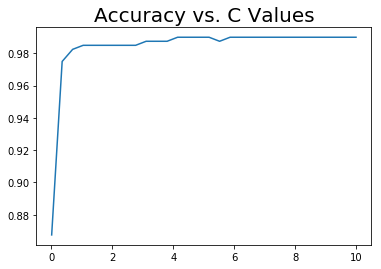

0.99
4.14379310345


In [12]:
#lets tune C, given the previous best gamma
c_list = np.linspace(.01,10,30)
performance = []

for c in c_list:
    
    #train a model
    clf = svm.SVC(gamma= g, C=c)
    clf.fit(X_train, y_train)
    
    #predict on the test dataset
    predictions = clf.predict(X_test)

    #get the accuracy
    performance.append(accuracy_score(y_test, predictions))
    
#plot
plt.plot(c_list, performance)
plt.title("Accuracy vs. C Values", fontsize = 20)
plt.show()

#train the model with the best kernel
clf_best_c = svm.SVC(gamma=g, C = c_list[np.argmax(performance)])
clf_best_c.fit(X_train, y_train)

#predict on the test dataset
predictions_best_c = clf_best_c.predict(X_test)

#get the accuracy
print (accuracy_score(y_test, predictions_best_c))
print(c_list[np.argmax(performance)])

## Generate an ROC curve comparison of all the SVM models tested

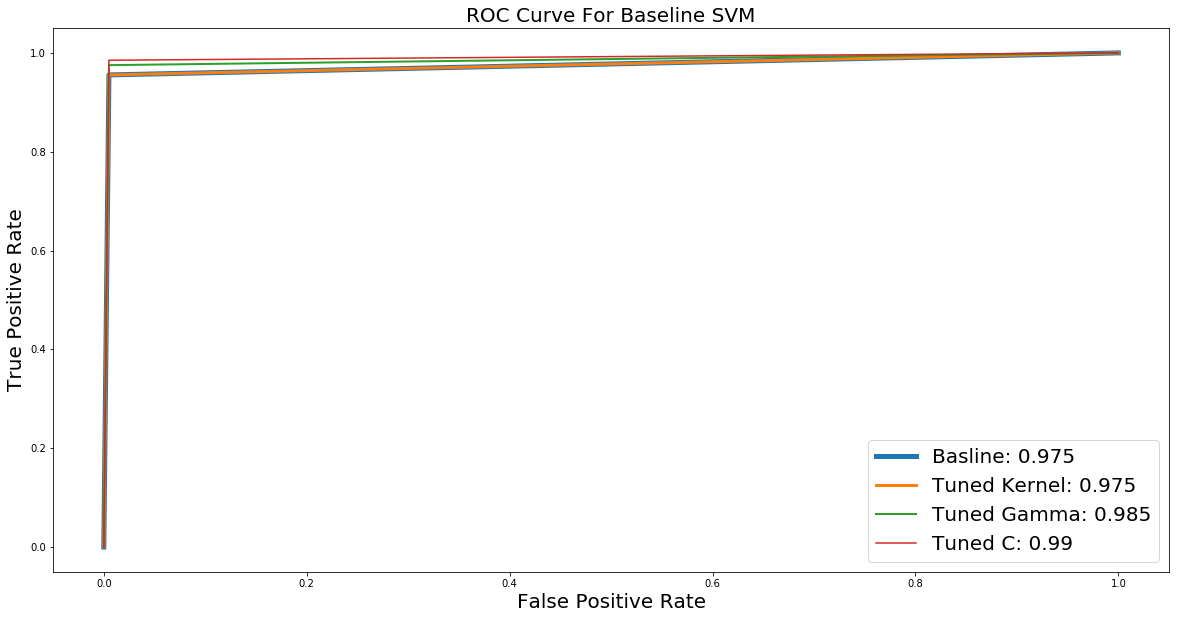

In [13]:
plt.figure(figsize=(20,10))

#generate the ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_baseline)
a1 = round(metrics.auc(fpr, tpr), 3)
plt.plot(fpr, tpr, linewidth = 5)

#generate the ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_best_kernel)
a2 = round(metrics.auc(fpr, tpr), 3)
plt.plot(fpr, tpr, linewidth = 3)

#generate the ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_best_gamma)
a3 = round(metrics.auc(fpr, tpr), 3)
plt.plot(fpr, tpr, linewidth = 2)

#generate the ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_best_c)
a4 = round(metrics.auc(fpr, tpr), 3)
plt.plot(fpr, tpr)

#save these for later in the code
fpr_hist = fpr
tpr_hist = tpr
y_test_hist = y_test

plt.legend(['Basline: ' + str(a1), 'Tuned Kernel: ' + str(a2), 'Tuned Gamma: ' + str(a3), 'Tuned C: '+str(a4)], fontsize=20)
plt.title("ROC Curve For Baseline SVM", fontsize=20)
plt.xlabel("False Positive Rate", fontsize = 20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.show()

## Next lets compare another feature vector
I have already trained the SVM using color histograms. Next we will consider another kind of feature vector, histogram oriented gradient. 

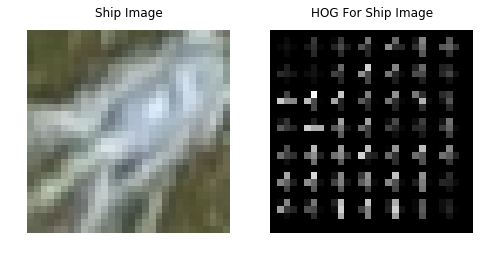

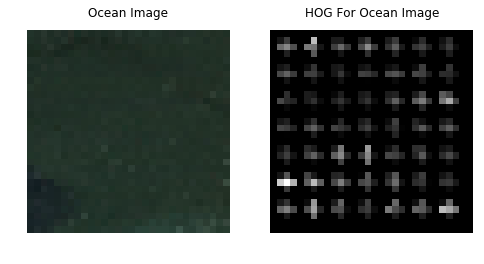

In [14]:
testImage = cv2.cvtColor(imagesOfShips[3], cv2.COLOR_BGR2GRAY)
testImage = cv2.resize(testImage, (30,30))

features, hogImage = hog(testImage, orientations=4, pixels_per_cell=(4, 4),
                         cells_per_block=(4, 4), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.set_title('Ship Image')
#plot the source color image
ax1.imshow(cv2.resize(imagesOfShips[3], (30,30)))

ax2.axis('off')
ax2.set_title('HOG For Ship Image')
ax2.imshow(hogImage, cmap='gray')
plt.show()

testImage = cv2.cvtColor(imagesOfOcean[3], cv2.COLOR_BGR2GRAY)
testImage = cv2.resize(testImage, (30,30))

features, hogImage = hog(testImage, orientations=4, pixels_per_cell=(4, 4),
                         cells_per_block=(4, 4), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.set_title('Ocean Image')
#plot the source color image
ax1.imshow(cv2.resize(imagesOfOcean[3], (30,30)))

ax2.axis('off')
ax2.set_title('HOG For Ocean Image')
ax2.imshow(hogImage, cmap='gray')
plt.show()

## Extract HOG from each image in the dataset

In [15]:
#containers for data
features = []
labels = []

#loop over the ships to make feature vectors
for i in range(len(imagesOfShips)):
    
    #resize the image to 30x30 and convert to grayscale
    image = cv2.resize(imagesOfShips[i], (30,30))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #get the HOG
    hog_image = hog(image, orientations=4, pixels_per_cell=(4, 4),
                             cells_per_block=(4, 4), visualise=False)
    
    #add to the dataset
    features.append(hog_image)
    labels.append(1)
    
#loop over the ocean to make feature vectors
for i in range(len(imagesOfOcean)):
    
    #resize the image to 30x30 and convert to grayscale
    image = cv2.resize(imagesOfOcean[i], (30,30))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    #get the HOG
    hog_image = hog(image, orientations=4, pixels_per_cell=(4, 4),
                             cells_per_block=(4, 4), visualise=False)
    
    #add to the dataset
    features.append(hog_image)
    labels.append(0)
    
#normalize the dataset
maxSet = np.max(features)
minSet = np.min(features)
for i in range(len(features)):
    
    #use min subtraction and max division norm
    features[i] = (features[i] - minSet) / (maxSet - minSet)
    
#shuffle the data
features, labels = shuffle(features, labels)

#split into training and validation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

## Pick the best kernel for the job

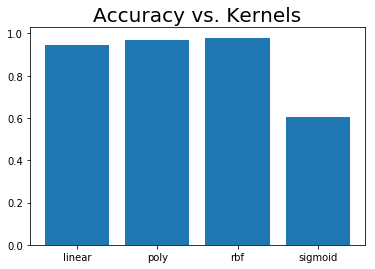

0.98


In [16]:
#check some kernel options
kernel_options = ["linear", "poly", "rbf", "sigmoid"]
performance = []

for ker in kernel_options:
    
    #train a model
    clf = svm.SVC(kernel=ker)
    clf.fit(X_train, y_train)
    
    #predict on the test dataset
    predictions = clf.predict(X_test)

    #get the accuracy
    performance.append(accuracy_score(y_test, predictions))

#plot
plt.title("Accuracy vs. Kernels", fontsize = 20)
plt.bar([0,1,2,3], performance)
plt.xticks([0,1,2,3],kernel_options)
plt.show()

#train the model with the best kernel
clf = svm.SVC()
clf.fit(X_train, y_train)

#predict on the test dataset
predictions_best_kernel_hog = clf.predict(X_test)

#get the accuracy
print (accuracy_score(y_test, predictions_best_kernel_hog))

## Now tune gamma for HOG

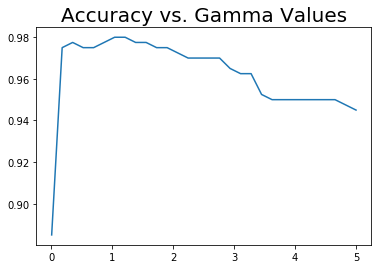

0.98
6
1.0424137931


In [17]:
#lets tune gamma
gamma_list = np.linspace(.01,5,30)
performance = []

for gam in gamma_list:
    
    #train a model
    clf = svm.SVC(gamma=gam)
    clf.fit(X_train, y_train)
    
    #predict on the test dataset
    predictions = clf.predict(X_test)

    #get the accuracy
    performance.append(accuracy_score(y_test, predictions))
    
#plot
plt.title("Accuracy vs. Gamma Values", fontsize = 20)
plt.plot(gamma_list, performance)
plt.show()

#train the model with the best kernel
clf = svm.SVC(gamma=gamma_list[np.argmax(performance)])
clf.fit(X_train, y_train)

#predict on the test dataset
predictions_best_gamma_HOG = clf.predict(X_test)

#get the accuracy
print (accuracy_score(y_test, predictions_best_gamma_HOG))

print (np.argmax(performance))
g = gamma_list[np.argmax(performance)]
print(g)

## Tune c for HOG

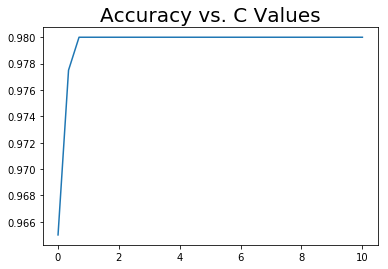

0.98
0.698965517241


In [18]:
#lets tune C, given the previous best gamma
c_list = np.linspace(.01,10,30)
performance = []

for c in c_list:
    
    #train a model
    clf = svm.SVC(gamma = g, C=c)
    clf.fit(X_train, y_train)
    
    #predict on the test dataset
    predictions = clf.predict(X_test)

    #get the accuracy
    performance.append(accuracy_score(y_test, predictions))
    
#plot
plt.plot(c_list, performance)
plt.title("Accuracy vs. C Values", fontsize = 20)
plt.show()

#train the model with the best kernel
clf = svm.SVC(gamma=g, C = c_list[np.argmax(performance)])
clf.fit(X_train, y_train)

#predict on the test dataset
predictions_best_c_HOG = clf.predict(X_test)

#get the accuracy
print (accuracy_score(y_test, predictions_best_c_HOG))
print(c_list[np.argmax(performance)])

## Compare the model with color histograms vs. HOG

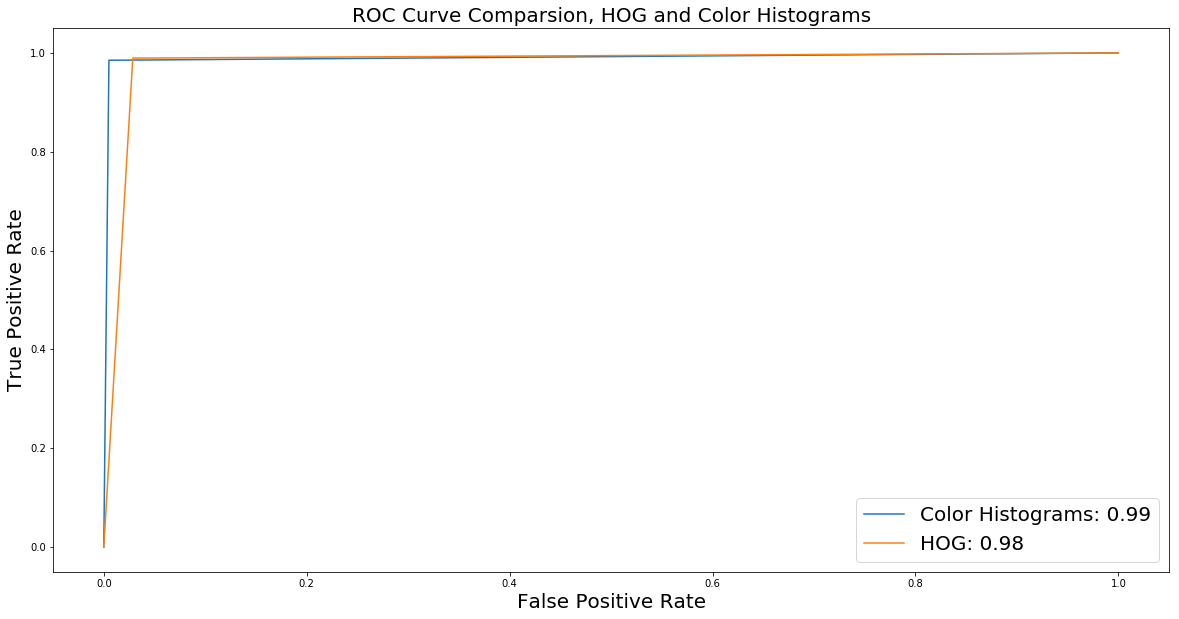

In [19]:
plt.figure(figsize=(20,10))

#for color histograms
plt.plot(fpr_hist, tpr_hist)
a2 = round(metrics.auc(fpr_hist, tpr_hist), 3)

#generate the ROC curve data
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_best_c_HOG)
a1 = round(metrics.auc(fpr, tpr), 3)
plt.plot(fpr, tpr)

plt.legend(['Color Histograms: ' + str(a2), 'HOG: ' + str(a1)], fontsize=20)
plt.title("ROC Curve Comparsion, HOG and Color Histograms", fontsize=20)
plt.xlabel("False Positive Rate", fontsize = 20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.show()

In [20]:
print (classification_report(y_test_hist, predictions_best_c, digits=4))

              precision    recall  f1-score   support

           0     0.9850    0.9949    0.9899       198
           1     0.9950    0.9851    0.9900       202

    accuracy                         0.9900       400
   macro avg     0.9900    0.9900    0.9900       400
weighted avg     0.9900    0.9900    0.9900       400



In [21]:
print (classification_report(y_test, predictions_best_c_HOG, digits=4))

              precision    recall  f1-score   support

           0     0.9903    0.9714    0.9808       210
           1     0.9691    0.9895    0.9792       190

    accuracy                         0.9800       400
   macro avg     0.9797    0.9805    0.9800       400
weighted avg     0.9802    0.9800    0.9800       400



In [29]:
#save out the ROC data for comparison
np.save("SVM_HOG.npy", np.column_stack((fpr,tpr)))
np.save("SVM_HIST.npy", np.column_stack((fpr_hist, tpr_hist)))